In [ ]:
#reference: https://thecleverprogrammer.com/2021/11/10/article-recommendation-system-with-machine-learning/
# dataset: https://www.kaggle.com/datasets/cryptexcode/mpst-movie-plot-synopses-with-tags

Everyone likes movies. But what kind of movies? Well it differs from person to person. But you find that you and your friend have same interest on certain movies. How do you know that? You start noticing the things that makes you and your friend like the movie.

Maybe you like the movie because of its casting and your friend likes it because of its genre or the director. Our objective is to look at the plots of the movie to see other movies that might interest you. Lets see how we make a machine learn this to suggest new movies.

The dataset for our problem is taken from kaggle: [movie_data.csv](https://www.kaggle.com/datasets/cryptexcode/mpst-movie-plot-synopses-with-tags)

Download the given dataset from kaggle and upload it as file in your google collab notebook.
### Note: The files that you upload will be available until the session is active or the window is closed. So you will have to re-upload the file everytime in a new session.

Enough talk. Lets code.

Lets start by checking our data

In [ ]:
import pandas as pd
data = pd.read_csv("movie_data.csv" ,engine='python', error_bad_lines=False)
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 8933: unexpected end of data


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


**Origin, Director, Cast, Genre, Plot** - These are the features that we can use to recommend new movies. But we are particularly interested in "Plots" since it has more text for us to process. We can also use combinations of other listed features. Another reason for choosing Plots is to reduce the bias.
Let us explain: You might like a movie just for its cast, but it might turn out to be a terrible one. Our goal is to suggest a movie that you might like. Hence if you already like a movie, it is more probable that you might like a movie with a similar plot.

The plot of the movie might have special characters and stop words like "in, the, as". These are not significant for recommending movies and hence we can remove such words. Also "Hero" and "hero" should be considered as same words. Similarly "going" and "go" are the same words.
Let's do some cleaning to incorporate these ideas, shall we!

In [ ]:
import nltk
import nltk.corpus
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english')
plotlist = data.plot_synopsis.tolist();

lem = WordNetLemmatizer()
for p in range(0, len(plotlist)):
  plot = plotlist[p]
  tokens = plot.split()
  for i in range(len(tokens)):
    if(tokens[i] in stop_words):
        tokens[i] = ""
    else:
      tokens[i] = tokens[i].lower()
    tokens[i] = lem.lemmatize(tokens[i])
  plotlist[p] =  " ".join(tokens)+" "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


A small detour. Lets try to generate a word cloud of the most used words in movie plots. Similar exploration of the data will help us to understand the dataset more and will help in getting a little more insight.

In [ ]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


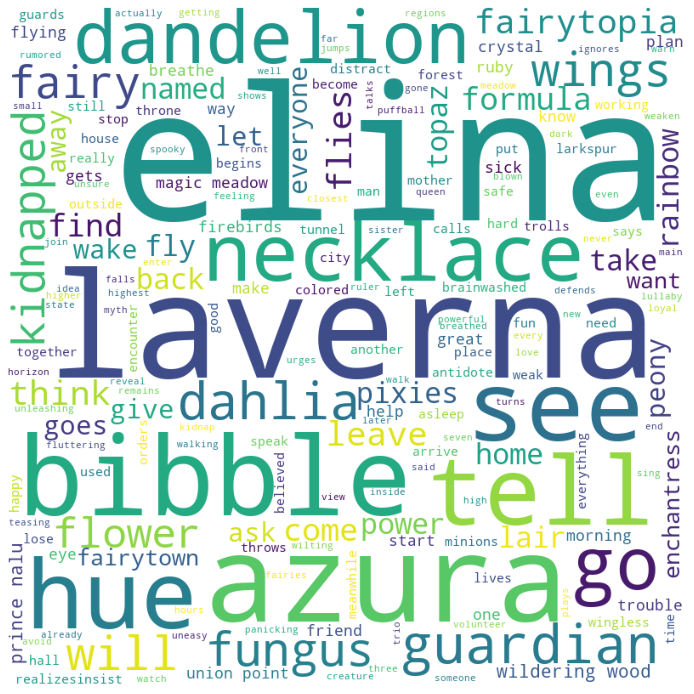

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stop_words = set(STOPWORDS)
all_plots = data["plot_synopsis"].tolist()
for plot in all_plots:
  tokens = plot.split()
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  all_tokens = " ".join(tokens)+" "
cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10, stopwords=stop_words).generate(all_tokens)
plt.figure(figsize=(10,10), facecolor=None)
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout(pad = 2)
plt.show()

Lets get back to our recommendation problem.

In [ ]:
all_plots = data["plot_synopsis"].tolist()
from sklearn.feature_extraction import text
tfidf = text.TfidfVectorizer(input=all_plots, stop_words='english')
matrix = tfidf.fit_transform(all_plots)
pd.DataFrame(matrix).head()

,0
0,"(0, 83314)\t0.02577630728824167\n (0, 35301..."
1,"(0, 96664)\t0.02945917719906142\n (0, 91108..."
2,"(0, 18478)\t0.018050733842199244\n (0, 3195..."
3,"(0, 23966)\t0.010630645635498976\n (0, 7098..."
4,"(0, 38493)\t0.007884587875737892\n (0, 1287..."


Woah..Wait what is all that!.
Lets go line by line
we are converting the dataframe of plots into a list. Computers cannot understand text directly (Obviously!). Hence we have to spoonfeed them numbers as input.
What is TFIDF: It stands for Term Frequency - Inverse Document Frequency. Term Frequency is how many times a given word is encountered in a document. The inverse document frequency is a measure of how rare or common a given word in all the documents. This is a value between 0 and 1. So for rare words the value will reach 1 and 0 for common words.

The **TfidfVectorizer** from sklearn is used to convert each words to a vector, meaning, each word is assigned a vector space. Now that we have our text as vectors, we can use this run our model on recommending new movies.

Now that we have our plots as vectors, lets find all the movies matches or similar to a given plot. This is achived using cosine similarity.
Cosine similarity is the dot product of the 2 vectors divided by the product of nrom of the two vectors.

norm of a vector is square root of sum of squares of individual elements of the vector.

cosine_similarity = (A . B) / (||A||.||B||).

sklearn cosine_similarity function performs this and returns a similarity matrix.

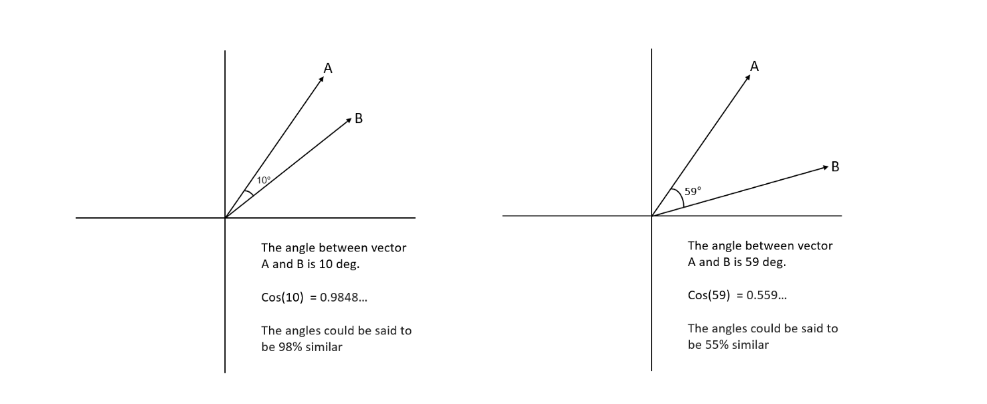

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(matrix)
similarity

array([[1.        , 0.00724776, 0.01540849, ..., 0.0117552 , 0.00878719,
        0.00561123],
       [0.00724776, 1.        , 0.01942559, ..., 0.00399072, 0.00411241,
        0.00299518],
       [0.01540849, 0.01942559, 1.        , ..., 0.00204747, 0.0035921 ,
        0.00364913],
       ...,
       [0.0117552 , 0.00399072, 0.00204747, ..., 1.        , 0.00790529,
        0.00438512],
       [0.00878719, 0.00411241, 0.0035921 , ..., 0.00790529, 1.        ,
        0.00168073],
       [0.00561123, 0.00299518, 0.00364913, ..., 0.00438512, 0.00168073,
        1.        ]])

As you can see, the diagonal of each row is 1, meaning the similarity  between the vector and itself is 1. Hence while suggesting movies, the same movie should be ignored.

Now for each of the plots, we run a cosine similarity with all the other plots. The movies with greater value are more similar to the given movie plot. We get the list of movies that has similar plots and add their title as a new column in our dataframe.

In [ ]:
def recommend_movies(x):
    return ", ".join(data["title"].loc[x.argsort()[-5:-1]])
    # sort the simlarity values and return the last 4 values

In [ ]:
data["Recommended_Movies"] = [recommend_movies(x) for x in similarity]
res = data[['title', 'Recommended_Movies']]


Lets see our suggestions. 'res' will have the title of a movie and best 4 recommended movies.

In [ ]:
res[50:75]

,title,Recommended_Movies
50,Alien,"Kapringen, Under Siege, The Core, Hatari!"
51,Hotel Chevalier,"In Time, A Hard Day's Night, I tre volti della..."
52,Spud,"Mr. Holland's Opus, Cat's Eye, 14 Going on 30,..."
53,Timber Falls,"Saints and Soldiers, Crimson Tide, 17 Again, Noel"
54,The Core,"Call of Duty: Modern Warfare 3, Under Siege, J..."
55,"Now, Voyager","The Amazing Spider-Man, Antares, Stella, The Help"
56,Rivals,"Antares, Brokeback Mountain, Captain America: ..."
57,A Most Violent Year,"Mad Max 2, In Time, Bowling for Columbine, The..."
58,Stella,"In Time, Captain America: The Winter Soldier, ..."
59,The Men Who Stare at Goats,"War Room, W., A Single Man, Taste of Fear"
